In [2]:
!pip install keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394 kB 5.1 MB/s 


In [83]:
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
import pandas as pd 
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Rescaling, Reshape, Dropout

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Metadata: label and path of each image
characters_data_url = "drive/My Drive/Colab Notebooks/OCR-data/characters/"
characters = pd.read_csv(characters_data_url + "english.csv")
characters.head()

,image,label
0,Img/img001-001.png,0
1,Img/img001-002.png,0
2,Img/img001-003.png,0
3,Img/img001-004.png,0
4,Img/img001-005.png,0


(900, 1200, 3)


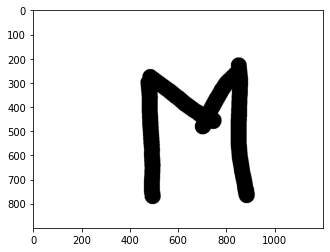

In [6]:
# Show a single image to have an idea of the data
img = image.imread(characters_data_url+characters['image'][1234])
print(img.shape)
plt.imshow(img)
plt.show()

In [93]:
# Number of images in a batch
batch_size = 32
# The desired image size
img_height = 180
img_width = 240

In [94]:
classes = characters['label'].unique() # list of classes
num_classes=len(characters['label'].unique()) # number of classes (10 diits + 26 lowercase + 26 uppercase = 62)
label_to_int = {classes[i]:i for i in range(num_classes)} # dict to get an unique id as int for each class
int_to_label = {value:key for key, value in label_to_int.items()} # dict to get back a string label from an int
labels = [label_to_int[l] for l in characters['label']] # list of labels as int

In [95]:
# Prepare the data stream batches (it avoids to overload the RAM)
train_ds = tf.keras.utils.image_dataset_from_directory(
    characters_data_url,
    labels = labels,
    batch_size = batch_size,
    image_size = (img_height, img_width),
    color_mode = 'grayscale',
    seed=10,
    validation_split = 0.2,
    shuffle=True,
    subset = "training"
    )

# For some reason the labels are definitely shuffled and need to be redifined
labels = [label_to_int[l] for l in characters['label']]

val_ds = tf.keras.utils.image_dataset_from_directory(
    characters_data_url,
    labels = labels,
    batch_size = batch_size,
    image_size = (img_height, img_width),
    color_mode = 'grayscale',
    seed=10,
    validation_split = 0.2,
    shuffle=True,
    subset = "validation"
    )

Found 3410 files belonging to 1 classes.
Using 2728 files for training.
Found 3410 files belonging to 1 classes.
Using 682 files for validation.


(32, 180, 240, 1)
(32,)


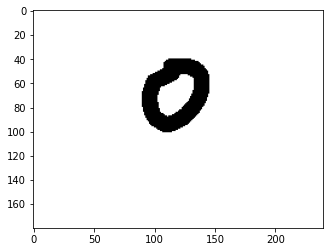

O


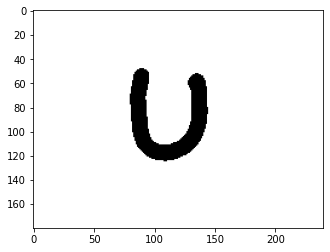

U


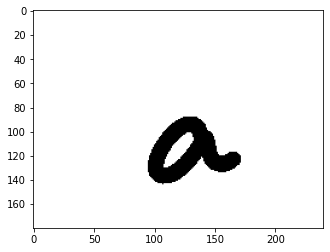

a


In [96]:
# Check that the labels are correct
for image, label in val_ds:
    print(image.shape)
    print(label.shape)
    for i in range(3):
      plt.imshow(np.reshape(image[i],(img_height, img_width)), cmap="gray")
      plt.show()
      print(int_to_label[label.numpy()[i]])
    break

In [97]:
# Better memory performances
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [98]:
img_shape = (img_height, img_width, 1)

# define model
model1 = Sequential([
    Rescaling(1./255, input_shape=img_shape),
    Conv2D(16, padding='same', kernel_size=(3,3), activation='relu'),
    MaxPooling2D(padding='same'),
    Conv2D(32, padding='same', kernel_size=(3,3), activation='relu'),
    MaxPooling2D(padding='same'),
    Conv2D(64, padding='same', kernel_size=(3,3), activation='relu'),
    MaxPooling2D(padding='same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='sigmoid')
])

In [99]:
# compile
learning_rate = 1e-3
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

In [100]:
# fit
MODEL_NAME = 'base_model'
logs = {}
EPOCHS = 10
logs[MODEL_NAME] = model1.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
)

Epoch 1/10
86/86 [==============================] - 33s 104ms/step - loss: 3.9246 - accuracy: 0.0726 - val_loss: 3.4340 - val_accuracy: 0.1584
Epoch 2/10
86/86 [==============================] - 2s 28ms/step - loss: 2.7303 - accuracy: 0.3178 - val_loss: 2.6717 - val_accuracy: 0.3416
Epoch 3/10
86/86 [==============================] - 3s 32ms/step - loss: 1.5912 - accuracy: 0.5748 - val_loss: 2.3995 - val_accuracy: 0.4326
Epoch 4/10
86/86 [==============================] - 3s 30ms/step - loss: 0.8028 - accuracy: 0.7742 - val_loss: 2.3897 - val_accuracy: 0.4839
Epoch 5/10
86/86 [==============================] - 2s 27ms/step - loss: 0.3599 - accuracy: 0.8966 - val_loss: 2.8115 - val_accuracy: 0.4648
Epoch 6/10
86/86 [==============================] - 2s 28ms/step - loss: 0.1404 - accuracy: 0.9622 - val_loss: 3.2924 - val_accuracy: 0.4956
Epoch 7/10
86/86 [==============================] - 2s 27ms/step - loss: 0.0606 - accuracy: 0.9839 - val_loss: 3.7679 - val_accuracy: 0.4809
Epoch 8/10


In [15]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

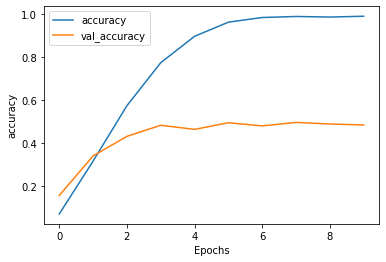

In [101]:
plot_graphs(logs[MODEL_NAME], 'accuracy')

Quite poor model

In [107]:
%cd "/content/drive/MyDrive/Colab Notebooks/Handwriting-recognition"

/content/drive/MyDrive/Colab Notebooks/Handwriting-recognition


In [108]:
!git 

Initialized empty Git repository in /content/drive/MyDrive/Colab Notebooks/Handwriting-recognition/.git/
